In [48]:
#Misterious command that makes everything work with keras
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from TrainModel import createImageDataset, showImages
from pathlib import Path
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, Input, BatchNormalization, Softmax
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model


# Training EEG autoencoders

## Define Model


In [49]:
def createEncoder(input_size):
    input_img = Input(shape=(input_size))
    
    x = Conv2D(16, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    #Encoded size (4,4,32)
    return Model(input_img, encoded)
    
def createDecoder(input_size):
    encoded = Input(shape=input_size)
    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    
    return Model(encoded, decoded)

def createConvolutionalAutodenoiser(input_size):
    encoder = createEncoder(input_size)
    print(encoder.output.shape)
    decoder = createDecoder(encoder.output.shape[1:])
    
    input_img = Input(shape=(input_size))
    encoded_img = encoder(input_img)
    decoded_img = decoder(encoded_img)
    
    model = Model(input_img, decoded_img)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

autoencoder = createConvolutionalAutodenoiser((32,32,3))
print(autoencoder.layers[1].summary())
print(autoencoder.summary())

(None, 4, 4, 32)
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_94 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_94 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_95 (Batc (None, 16, 1


## Load data

In [50]:
img_size = 32
frame_duration = 1 
overlap = 0.2

In [13]:

#Arithmetic dataset
dataPath = Path(r"C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\ArithmeticCalibrationProcedure\edf")
X_arith, y_arith = createImageDataset(dataPath,imageSize=img_size,frameDuration=frame_duration,overlap=overlap,
                          image_format=True, augment_data=False, labels = ["EasyAdd","HardMult"],
                          lstm_format=False, lstm_sequence_length=None,
                         fileNameFormat=2)

# Eyes open-close dataset
dataPath = Path(r'C:\Users\asus\OneDrive - purdue.edu\RealtimeProject\Experiments3-Data\EyesOpen_closeDataset\edf')
X_eyes, y_eyes = createImageDataset(dataPath,imageSize=img_size,frameDuration=frame_duration,overlap=overlap,
                          image_format=True, augment_data=False, labels = ["EyesClosed","EyesOpen"],
                          lstm_format=False, lstm_sequence_length=None,
                         fileNameFormat=2)


file information: UJing 1 1 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 2 HardMult
38 frames generated with label  1.0/38
file information: UJing 1 3 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 4 HardMult
38 frames generated with label  1.0/38
file information: UJing 1 5 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 6 HardMult
38 frames generated with label  1.0/38
file information: UJing 1 7 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 8 HardMult
38 frames generated with label  1.0/38
file information: UJing 1 9 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 10 HardMult
38 frames generated with label  1.0/38
file information: UJing 1 11 EasyAdd
38 frames generated with label  0.0/38
file information: UJing 1 12 HardMult
38 frames generated with label  1.0/38
file information: UJing 2 1 EasyAdd
38 frames generated with label  0.0/38
file information

In [51]:

#Concatenate
X =  np.concatenate((X_arith,X_eyes))
y =  np.concatenate((y_arith,y_eyes))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

##Normalize the dataset

##Method 1: Normalize with global mean and std
# global_mean = x_train.mean(); global_std = x_train.std();
# x_train = (x_train - global_mean)/global_std;
# x_test = (x_test - global_mean)/global_std;

print("arithm data",X_arith.shape, "eyes data",X_eyes.shape)
print("train", x_train.shape,"test",x_test.shape)


arithm data (2352, 32, 32, 3) eyes data (4200, 32, 32, 3)
train (5241, 32, 32, 3) test (1311, 32, 32, 3)


## Train autoencoder and plot results


In [52]:
batch_size = 128
num_classes = 2
epochs = 200
input_shape = (img_size, img_size, 3)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


autoencoder = createConvolutionalAutodenoiser(input_shape)

history = autoencoder.fit(x_train, x_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, x_test),
          shuffle=True)

(None, 4, 4, 32)
Train on 5241 samples, validate on 1311 samples
Epoch 1/200
5241/5241 [==============================] - 3s 554us/sample - loss: 0.6376 - val_loss: 0.6344
Epoch 2/200
5241/5241 [==============================] - 1s 127us/sample - loss: 0.6059 - val_loss: 0.6066
Epoch 3/200
5241/5241 [==============================] - 1s 142us/sample - loss: 0.5921 - val_loss: 0.5890
Epoch 4/200
5241/5241 [==============================] - 1s 144us/sample - loss: 0.5804 - val_loss: 0.5753
Epoch 5/200
5241/5241 [==============================] - 1s 112us/sample - loss: 0.5696 - val_loss: 0.5634
Epoch 6/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.5597 - val_loss: 0.5498
Epoch 7/200
5241/5241 [==============================] - 1s 111us/sample - loss: 0.5502 - val_loss: 0.5383
Epoch 8/200
5241/5241 [==============================] - 1s 111us/sample - loss: 0.5415 - val_loss: 0.5237
Epoch 9/200
5241/5241 [==============================] - 1s 112us/sample - loss

5241/5241 [==============================] - 1s 114us/sample - loss: 0.3780 - val_loss: 0.3792
Epoch 152/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3780 - val_loss: 0.3789
Epoch 153/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3780 - val_loss: 0.3789
Epoch 154/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3780 - val_loss: 0.3789
Epoch 155/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3778 - val_loss: 0.3789
Epoch 156/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3779 - val_loss: 0.3791
Epoch 157/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3779 - val_loss: 0.3788
Epoch 158/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3779 - val_loss: 0.3788
Epoch 159/200
5241/5241 [==============================] - 1s 114us/sample - loss: 0.3778 - val_loss: 0.3790
Epoch 160/200
5241/5241 [========

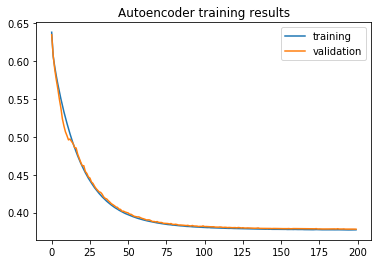

In [53]:
import matplotlib.pyplot as plt
history.history.keys()

fig,ax = plt.subplots(1,1)
ax.set_title('Autoencoder training results')
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.legend()

## Plot some images

In [55]:
def showOrigDec(orig, reconstructed, num=10):
    
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(reconstructed[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


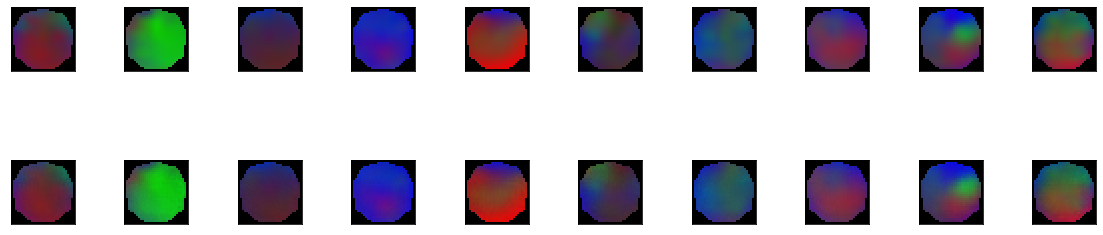

In [56]:
reconstructed = autoencoder.predict(x_test)
showOrigDec(x_test, reconstructed)

In [57]:
#Save autoencoder
autoencoder.save('autoEncoderWeights/autoencoder.h5')

encoder = autoencoder.layers[1]
encoded_features = encoder(x_test)
encoded_features = Flatten()(encoded_features)
print(encoded_features.shape)

(1311, 512)
